In [6]:
import pandas as pd
import numpy 
import os
import git
import pickle
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot
import numpy as np

/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [8]:
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import SGD
from keras.models import Model, Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Reshape
from keras.layers import Average
from keras.layers import Dropout
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [9]:
## Read the labelled files and the poly_user
def get_git_root(path):
	git_repo = git.Repo(path, search_parent_directories=True)
	git_root = git_repo.git.rev_parse("--show-toplevel")
	return git_root

In [19]:
top_dir = os.path.join(get_git_root(os.getcwd()))
df_tweets = pd.read_csv(os.path.join(get_git_root(os.getcwd()),"input","labelled_data","tweets_predicted.csv"), lineterminator="\n", index_col=0)



In [14]:
# poly_dir = os.path.join(top_dir,"models","poly_users")
## switching to include rewteet data
poly_dir = os.path.join(top_dir,"models","poly_wrt")
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
normal_users = pickle.load(open(os.path.join(poly_dir,"normal_users.pkl"),"rb"))

In [15]:
print("total users", len(normal_users))
# 3177 with rt
# 2157 without rt

total users 2157


In [16]:
mono_users = list(set(normal_users) - set(poly_users))

In [20]:
print("total tweets: ",len(df_tweets))
print("total users: ",len(df_tweets.userID.unique()))

total tweets:  111274
total users:  4857


In [21]:
poly_tweets = df_tweets.loc[df_tweets.userID.isin(poly_users)]

In [22]:
mono_tweets = df_tweets.loc[df_tweets.userID.isin(mono_users)]

In [27]:
df_tweets_normal = df_tweets.loc[df_tweets.userID.isin(normal_users)]
len(df_tweets_normal)

76585

In [24]:
## without rt
print("all tweets by poly users: ", len(poly_tweets))
print("poly users (based with retweets):", len(poly_tweets.userID.unique()))

all tweets by poly users:  61605
poly users (based with retweets): 565


In [12]:
## with rt
print("all tweets by poly users: ", len(poly_tweets))
print("poly users (based with retweets):", len(poly_tweets.userID.unique()))

all tweets by poly users:  97565
poly users (based with retweets): 979


In [13]:
print("all tweets by mono users: ", len(mono_tweets))
print("mono users (based with retweets):", len(mono_tweets.userID.unique()))

all tweets by mono users:  8244
mono users (based with retweets): 2198


In [25]:
## without rt
print("all tweets by mono users: ", len(mono_tweets))
print("mono users (based with retweets):", len(mono_tweets.userID.unique()))

all tweets by mono users:  14980
mono users (based with retweets): 1592


## Preparing the data

In [28]:
no_tweets = list()
for user in mono_users:
    tweets =(mono_tweets.loc[mono_tweets.userID == user])
    no_tweets.append((user,len(tweets)))
df_user = pd.DataFrame(no_tweets, columns=["userID","len_tweets"])
df_user = df_user.sort_values(by="len_tweets",ascending=True)

In [29]:
users = df_user.userID.unique()
i = 0
users_no = dict()
users_no[0] = 0
## sorted non-decreasing list  
for idx,element in df_user.iterrows():
    if (element["len_tweets"] < (i + 50)):
        users_no[i] += 1 
    else:
        i = i + 50
        users_no[i] = 1

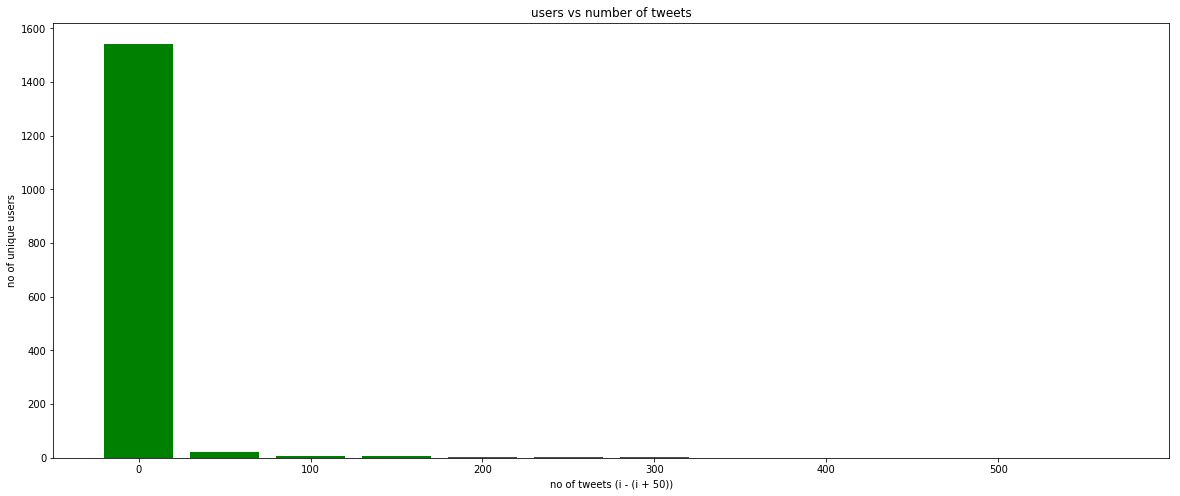

In [30]:
## poly users
plt.figure(figsize= (20,8))
plt.bar(users_no.keys(), users_no.values(), width = 40, color= "green")
plt.xlabel("no of tweets (i - (i + 50))")
plt.ylabel("no of unique users")
plt.title("users vs number of tweets")
plt.show()

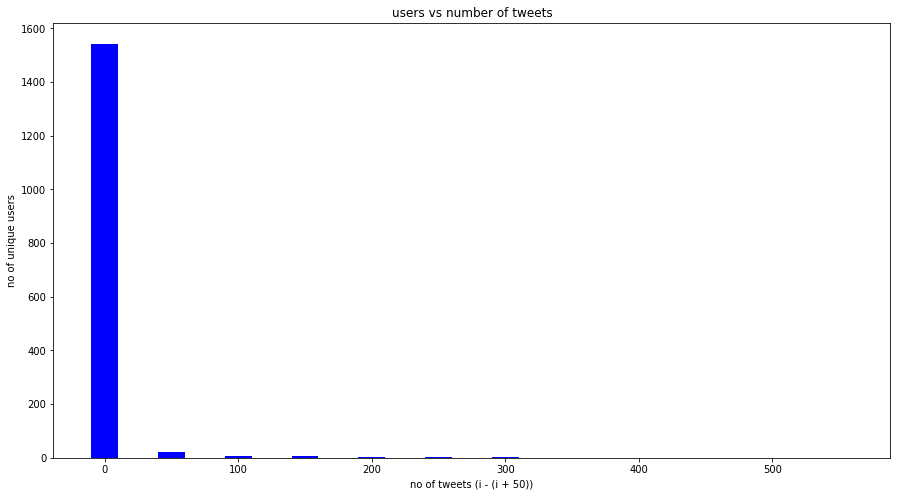

In [31]:
## mono users
plt.figure(figsize= (15,8))
plt.bar(users_no.keys(), users_no.values(), width = 20, color= "blue")
plt.xlabel("no of tweets (i - (i + 50))")
plt.ylabel("no of unique users")
plt.title("users vs number of tweets")
plt.show()

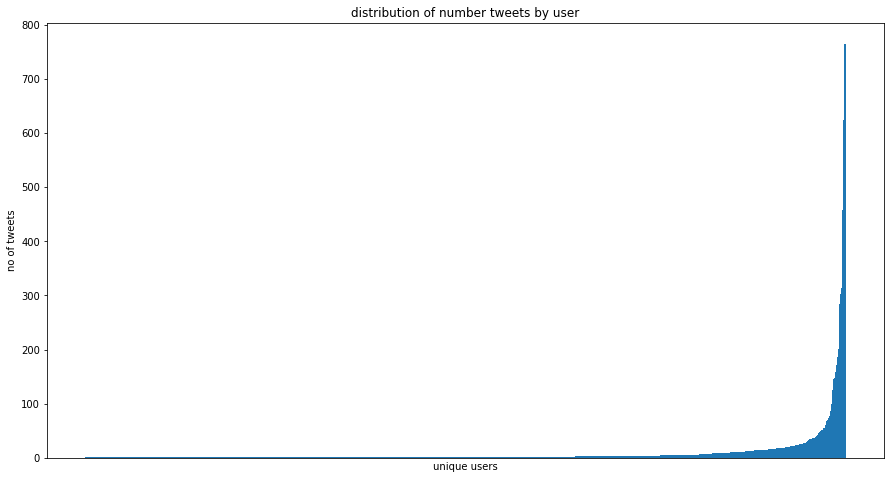

In [32]:
## mono users
plt.figure(figsize=(15,8))
plt.bar([str(user) for user in df_user["userID"]],df_user["len_tweets"],width=5)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False)
plt.xlabel("unique users", fontsize=10)
plt.ylabel("no of tweets",fontsize=10)
plt.title("distribution of number tweets by user")
plt.show()

In [33]:
## poly user
plt.figure(figsize=(15,8))
plt.bar([str(user) for user in df_polyt_user["userID"]],df_polyt_user["len_tweets"],width=5)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False)
plt.xlabel("unique users", fontsize=10)
plt.ylabel("no of tweets",fontsize=10)
plt.title("distribution of number tweets by user")
plt.show()

NameError: name 'df_polyt_user' is not defined

<Figure size 1080x576 with 0 Axes>

## preprocessing the tweets

In [35]:
## cleaning the tweets
import re
def clean_text(text):
    text = re.sub(r'(#)', "",text) ## removing the hashtags signal 
    text = re.sub(r'(RT \w+:)', "",text) ## remove the retweet info as they dont convey any information
    text = re.sub(r'(author)',"",text)
#     text = re.sub(r'')
    text.rstrip
    text.lstrip
    return(text)

In [36]:
import nltk
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/akshayuppal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akshayuppal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [38]:
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
def get_tokens(sentence):
#     tokens = nltk.word_tokenize(sentence)  # now using tweet tokenizer
    tokens = tknzr.tokenize(sentence)
    tokens = [token.lower() for token in tokens if (token not in stopwords and token.isalpha())] # stopwords removal
    tokens = [get_lemma(token) for token in tokens]  # lemmatization
    return (" ".join(tokens))

In [39]:
## return the tokenized words
def get_token(sentence):
    tokens = tknzr.tokenize(sentence)
    tokens = [token.lower() for token in tokens if (token not in stopwords and token.isalpha())] # stopwords removal
    tokens = [get_lemma(token) for token in tokens]  # lemmatization
    return (tokens)

In [40]:
## cleaning the text
poly_tweets["tweetText"] = poly_tweets["tweetText"].apply(clean_text)
mono_tweets["tweetText"] = mono_tweets["tweetText"].apply(clean_text)

In [41]:
## tokenizing and lemmatizing
poly_tweets["tweetText"] = (poly_tweets["tweetText"].apply(get_tokens))
mono_tweets["tweetText"] = mono_tweets["tweetText"].apply(get_tokens)

In [42]:
## join al the of the tweets for each user
def get_tweets_user(df):
    df_tweets_comb = list()
    users = df.userID.unique()
    for user in users:
        tweets =(df.loc[df.userID == user])
        tweets_f = (" . ".join(tweets["tweetText"]))
        df_tweets_comb.append((user,tweets_f))
    df_user = pd.DataFrame(df_tweets_comb, columns=["userID","tweetText"])
    return (df_user)

In [43]:
poly_tweets_user = get_tweets_user(poly_tweets)
mono_tweets_user = get_tweets_user(mono_tweets)

In [44]:
poly_tweets_user['label'] = "poly"
mono_tweets_user['label'] = "mono"

In [45]:
frames = [poly_tweets_user, mono_tweets_user]
final_tweets = pd.concat(frames)

In [46]:
len(final_tweets)

2157

In [64]:
## encode and pad the data
from keras.preprocessing.text import Tokenizer
def prepare_data(df_user, mode):
    # evaluate a neural network model
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(list(df_user["tweetText"]))
    X = tokenizer.texts_to_matrix(list(df_user["tweetText"]),mode=mode)
    le = LabelEncoder()
    le.fit(list(df_user["label"]))
    y = le.transform(list(df_user["label"]))
    X, y = shuffle(X, y, random_state=4)
    return (X,y)

In [65]:
## train test split
X, y = prepare_data(final_tweets,'binary')
X_train,X_test,Y_train,Y_test  = train_test_split(X, y,test_size =0.20,random_state= 4 )

In [66]:
X_train.shape

(1725, 40140)

In [67]:
X_test.shape

(432, 40140)

In [53]:
## Classification
def svm_wrapper(X_train,Y_train):
    param_grid = [
    {'C': [1, 10], 'kernel': ['linear']},
    {'C': [1, 10], 'gamma': [0.1,0.01], 'kernel': ['rbf']},]
    svm1 = GridSearchCV(SVC(),param_grid,verbose=4)
    svm1.fit(X_train, Y_train)
    return(svm1)

In [54]:
def mlp_wrapper(X_train,Y_train,epochs):
    n_words = X_test.shape[1]
    # define network
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(n_words,)))
    model.add(Dense(50, input_shape=(n_words,), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])  
    # fit network
    model.fit(X_train, Y_train, epochs=epochs, verbose=2)
    return model

In [57]:
X_test.shape

(432, 40140)

In [55]:
X_train.shape

(1725, 40140)

In [58]:
## SVM without PCA
svm = SVC(C=1,kernel='linear',verbose=2)
svm.fit(X_train,Y_train)
## svm
Y_pred = svm.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report SVM:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

[LibSVM]  Classification Report SVM:
              precision    recall  f1-score   support

          0       0.88      0.93      0.90       317
          1       0.76      0.64      0.70       115

avg / total       0.85      0.85      0.85       432
 



0.8518518518518519

In [59]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
rf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [60]:
## etree without PCA
etree = ExtraTreesClassifier(n_estimators=200)
etree.fit(X_train,Y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [61]:
## random forest without PCA
Y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report Random forest (without PCA):\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

  Classification Report Random forest (without PCA):
              precision    recall  f1-score   support

          0       0.78      0.98      0.87       317
          1       0.85      0.25      0.39       115

avg / total       0.80      0.79      0.74       432
 



0.7893518518518519

In [62]:
## etree without PCA
Y_pred = etree.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report Etree (without PCA):\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

  Classification Report Etree (without PCA):
              precision    recall  f1-score   support

          0       0.87      0.94      0.90       317
          1       0.79      0.60      0.68       115

avg / total       0.85      0.85      0.84       432
 



0.8518518518518519

In [63]:
mlp = mlp_wrapper(X_train,Y_train,epochs=10)
## mlp
temp = mlp.predict(X_test)
Y_pred = [0 if val<0.5 else 1 for val in temp]
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report MLP :\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 2s - loss: 0.4052 - acc: 0.8226
Epoch 2/10
 - 1s - loss: 0.2601 - acc: 0.8899
Epoch 3/10
 - 1s - loss: 0.1922 - acc: 0.9217
Epoch 4/10
 - 1s - loss: 0.1366 - acc: 0.9501
Epoch 5/10
 - 1s - loss: 0.1021 - acc: 0.9652
Epoch 6/10
 - 1s - loss: 0.0540 - acc: 0.9826
Epoch 7/10
 - 1s - loss: 0.0490 - acc: 0.9809
Epoch 8/10
 - 1s - loss: 0.0388 - acc: 0.9855
Epoch 9/10
 - 1s - loss: 0.0375 - acc: 0.9867
Epoch 10/10
 - 1s - loss: 0.0347 - acc: 0.9896
  Classification Report MLP :
              precision    recall  f1-score   support

          0       0.89      0.91      0.90       317
          1       0.74      0.68      0.71       115

avg / total       0.85      0.85      0.85       432
 



0.8518518518518519

### with pca

In [68]:
# tokenize and and get the vocalb
# vectorizer = TfidfVectorizer()

In [69]:
##reduce to lower dimesion  !! deprecated
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X_new = pca.fit_transform(X)

In [73]:
## svm 
svm = SVC(C=1,kernel='linear',verbose=2)
svm.fit(X_train,Y_train)
## svm
Y_pred = svm.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

[LibSVM]  Classification Report:
              precision    recall  f1-score   support

          0       0.88      0.93      0.90       317
          1       0.76      0.64      0.70       115

avg / total       0.85      0.85      0.85       432
 



0.8518518518518519

In [71]:
## random forest
Y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

  Classification Report:
              precision    recall  f1-score   support

          0       0.78      0.98      0.87       317
          1       0.85      0.25      0.39       115

avg / total       0.80      0.79      0.74       432
 



0.7893518518518519

In [72]:
## etree
Y_pred = etree.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

  Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.94      0.90       317
          1       0.79      0.60      0.68       115

avg / total       0.85      0.85      0.84       432
 



0.8518518518518519

## sentence level ..

In [74]:
poly_tweets["poly_mono"] = "poly"
mono_tweets["poly_mono"] = "mono"

In [75]:
frames = [poly_tweets, mono_tweets]
df_final_tweets = pd.concat(frames)

In [76]:
df_final_sentences = df_final_tweets[['tweetText','poly_mono']]

In [77]:
len(df_final_sentences)

76585

In [78]:
def get_data(df_user, mode):
    # evaluate a neural network model
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(list(df_user["tweetText"]))
    X = tokenizer.texts_to_matrix(list(df_user["tweetText"]),mode=mode)
    le = LabelEncoder()
    le.fit(list(df_user["label"]))
    y = le.transform(list(df_user["label"]))
    X, y = shuffle(X, y, random_state=4)
    return (X, y)

In [ ]:
# X,y  = get_data(df_final_tweets,'binary')
# X.shape

#### due to large vocabulary and memory errors using hashing vectorizer

In [81]:
from sklearn.feature_extraction.text import HashingVectorizer
hashing = HashingVectorizer(n_features=100)
vector = hashing.transform(df_final_sentences["tweetText"])
X = vector.toarray()

In [82]:
X.shape

(76585, 100)

In [83]:
le = LabelEncoder()
le.fit(list(df_final_sentences["poly_mono"]))
y = le.transform(list(df_final_sentences["poly_mono"]))

In [84]:
le.classes_

array(['mono', 'poly'], dtype='<U4')

In [85]:
X,y = shuffle(X,y, random_state=5)

In [86]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size =0.20,random_state= 4)

In [87]:
X_train.shape

(61268, 100)

In [ ]:
svm = svm_wrapper(X_train, Y_train)
## svm
Y_pred = svm.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

/home/samarthgoal/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=1, kernel=linear ..............................................
[CV] ..... C=1, kernel=linear, score=0.9221009356393536, total= 2.1min
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min remaining:    0.0s


[CV] ..... C=1, kernel=linear, score=0.9221009356393536, total= 2.2min
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.4min remaining:    0.0s


[CV] ..... C=1, kernel=linear, score=0.9220981747297536, total= 2.2min
[CV] C=10, kernel=linear .............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.7min remaining:    0.0s


[CV] .... C=10, kernel=linear, score=0.9221009356393536, total= 5.3min
[CV] C=10, kernel=linear .............................................
[CV] .... C=10, kernel=linear, score=0.9221009356393536, total= 5.3min
[CV] C=10, kernel=linear .............................................
[CV] .... C=10, kernel=linear, score=0.9220981747297536, total= 5.2min
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=1, gamma=0.1, kernel=rbf, score=0.9221009356393536, total=61.4min
[CV] C=1, gamma=0.1, kernel=rbf ......................................


In [114]:
svm = SVC(C=10,kernel='rbf')
svm.fit(X_train,Y_train)
## svm
Y_pred = svm.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

  Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.88       317
          1       0.80      0.37      0.51       115

avg / total       0.81      0.81      0.78       432
 



0.8078703703703703

In [113]:
rf = RandomForestClassifier(n_estimators=100, max_depth=20,
                             random_state=0,verbose=3)
rf.fit(X_train,Y_train)
Y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 10

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


0.8402777777777778

In [90]:
etree = ExtraTreesClassifier(n_estimators=200,verbose=3)
etree.fit(X_train,Y_train)
Y_pred = etree.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


  Classification Report:
              precision    recall  f1-score   support

          0       0.71      0.41      0.52      2990
          1       0.87      0.96      0.91     12327

avg / total       0.84      0.85      0.84     15317
 



[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.7s finished


0.851994515897369

## get the most common words in the poly and mono tweets

In [91]:
tokens_p = list(poly_tweets_user["tweetText"].apply(get_token))
tokens_j = list(mono_tweets_user["tweetText"].apply(get_token))

In [92]:
## get the list of tokens
## return the most common tokens
from collections import Counter
def build_vocab(tokens_list):
    vocab = Counter()
    for tokens in tokens_list:
        vocab.update(tokens)
    return vocab

In [93]:
## most common words for poly_users tweets
vocab = build_vocab(tokens_p)
vocab.most_common()[:30]

[('cannabis', 21853),
 ('tobacco', 19006),
 ('marijuana', 17350),
 ('weed', 10082),
 ('via', 6704),
 ('cbd', 5785),
 ('smoke', 4997),
 ('vape', 4683),
 ('pot', 4611),
 ('hemp', 4143),
 ('stone', 4005),
 ('smoking', 3951),
 ('use', 3677),
 ('new', 3602),
 ('vaping', 3511),
 ('get', 3242),
 ('product', 2879),
 ('medical', 2702),
 ('high', 2624),
 ('health', 2369),
 ('cigarette', 2344),
 ('tax', 2172),
 ('juul', 2025),
 ('stoner', 2012),
 ('us', 1998),
 ('legalizeit', 1589),
 ('find', 1578),
 ('stonerfam', 1560),
 ('big', 1546),
 ('industry', 1541)]

In [94]:
## most common words for juul user tweets
vocab1 = build_vocab(tokens_j)
vocab1.most_common()[:30]

[('tobacco', 5232),
 ('juul', 2734),
 ('cannabis', 1954),
 ('marijuana', 1870),
 ('smoke', 1713),
 ('vape', 1641),
 ('vaping', 1569),
 ('latest', 1471),
 ('smoking', 1450),
 ('thanks', 1290),
 ('daily', 1065),
 ('tax', 958),
 ('weed', 797),
 ('new', 748),
 ('ecig', 735),
 ('product', 720),
 ('via', 702),
 ('use', 665),
 ('health', 606),
 ('get', 595),
 ('cbd', 551),
 ('ecigs', 534),
 ('like', 514),
 ('cigarette', 481),
 ('fetish', 458),
 ('big', 446),
 ('http', 423),
 ('nicotine', 403),
 ('follow', 401),
 ('hemp', 381)]

In [95]:
## topic modelling
from gensim import corpora
import pickle
import pyLDAvis.gensim
dictionary = corpora.Dictionary(tokens_p)
corpus = [dictionary.doc2bow(text) for text in tokens_p]
pickle.dump(corpus, open(os.path.join(poly_dir,'corpus.pkl'), 'wb'))
dictionary.save(os.path.join(poly_dir,'dictionary.gensim'))

In [96]:
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=8)
ldamodel.save(os.path.join(poly_dir,'model5.gensim'))
topics = ldamodel.print_topics(num_words=4)

In [97]:
for topic in topics:
    print(topic)

(0, '0.044*"cannabis" + 0.038*"marijuana" + 0.014*"tobacco" + 0.008*"use"')
(1, '0.043*"cbd" + 0.031*"hemp" + 0.018*"cannabis" + 0.013*"vape"')
(2, '0.043*"cannabis" + 0.034*"weed" + 0.027*"marijuana" + 0.026*"stone"')
(3, '0.065*"marijuana" + 0.062*"cannabis" + 0.043*"via" + 0.038*"weed"')
(4, '0.081*"tobacco" + 0.013*"smoking" + 0.010*"cigarette" + 0.010*"vaping"')


In [98]:
## encode and pad the data
from keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle
def prepare_data(df_user, mode):
    # evaluate a neural network model
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(list(df_user["tweetText"]))
    X = tokenizer.texts_to_matrix(list(df_user["tweetText"]),mode=mode)
    le = LabelEncoder()
    le.fit(list(df_user["label"]))
    y = le.transform(list(df_user["label"]))
    X, y = shuffle(X, y, random_state=4)
    ## train test split
    X_train,X_test,Y_train,Y_test  = train_test_split(X, y,test_size =0.20,random_state= 4 )
    return (X_train,X_test,Y_train,Y_test)

In [99]:
## dont run again
import gensim
import os
import pyLDAvis.gensim
top_dir = os.path.join(get_git_root(os.getcwd()))
poly_dir = os.path.join(top_dir,"models","poly_users")
dictionary = gensim.corpora.Dictionary.load(os.path.join(poly_dir,'dictionary.gensim'))
corpus = pickle.load(open(os.path.join(poly_dir,'corpus.pkl'), 'rb'))
lda = gensim.models.ldamodel.LdaModel.load(os.path.join(poly_dir,'model5.gensim'))
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [100]:
dictionary = corpora.Dictionary(tokens_p)
corpus = [dictionary.doc2bow(text) for text in tokens_j]
pickle.dump(corpus, open(os.path.join(poly_dir,'corpus_m.pkl'), 'wb'))
dictionary.save(os.path.join(poly_dir,'dictionary_m.gensim'))
## LDA
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=8)
ldamodel.save(os.path.join(poly_dir,'model_m.gensim'))
topics = ldamodel.print_topics(num_words=4)

In [101]:
for topic in topics:
    print(topic)

(0, '0.013*"via" + 0.011*"cannabis" + 0.010*"smoke" + 0.010*"juul"')
(1, '0.025*"follow" + 0.024*"dank" + 0.020*"turnup" + 0.019*"cali"')
(2, '0.038*"marijuana" + 0.027*"cannabis" + 0.022*"latest" + 0.020*"smoke"')
(3, '0.035*"juul" + 0.032*"vape" + 0.019*"cannabis" + 0.019*"latest"')
(4, '0.068*"tobacco" + 0.014*"vaping" + 0.013*"tax" + 0.010*"smoking"')


In [102]:
## visualizing the mono tweets
## dont run again
import gensim
import os
import pyLDAvis.gensim
dictionary = gensim.corpora.Dictionary.load(os.path.join(poly_dir,'dictionary_m.gensim'))
corpus = pickle.load(open(os.path.join(poly_dir,'corpus_m.pkl'), 'rb'))
lda = gensim.models.ldamodel.LdaModel.load(os.path.join(poly_dir,'model_m.gensim'))
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [103]:
## mlp at tweet level and user level

In [104]:
## user level
frames = ( poly_tweets_user, mono_tweets_user)
df_user = pd.concat(frames)

In [105]:
def mlp_wrapper(X_train,X_test,Y_train,Y_test,epochs):
    n_words = X_test.shape[1]
    # define network
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(n_words,)))
    model.add(Dense(50, input_shape=(n_words,), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])  
    # fit network
    model.fit(X_train, Y_train, epochs=epochs, verbose=2)
    return model

In [106]:
def mlp_model():
    # define network
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(50829,)))
    model.add(Dense(50, input_shape=(50829,), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])  
    return model

In [107]:
len(df_user)

2157

In [108]:
X.shape

(76585, 100)

In [109]:
y.shape

(76585,)

In [110]:
Y_train.shape

(61268,)

In [111]:
X_test.shape

(15317, 100)

In [112]:
modes = ['binary', 'count', 'tfidf', 'freq']
results = pd.DataFrame()
for mode in modes:
    X_train,X_test,Y_train,Y_test = prepare_data(df_user,mode= mode)
    results[mode] = evaluate_model(X_train,X_test,Y_train,Y_test)

NameError: name 'evaluate_model' is not defined

In [ ]:
# summarize results f1
print(results.describe())
# plot results
results.boxplot()
pyplot.show()

In [ ]:
# summarize results accuarcy
print(results.describe())
# plot results
results.boxplot()
pyplot.show()

In [ ]:
## mlp (50 * 1) binary classification {mono,poly} 
## @Returns : runs cumulative scores <n_repeat times> on test set
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import precision_recall_fscore_support
def evaluate_model(X_train,X_test,Y_train,Y_test):
    scores = list()
    n_repeats = 10
    n_words = X_test.shape[1]
    for i in tqdm(range(n_repeats)):
        # define network
        model = Sequential()
        model.add(Dropout(0.2, input_shape=(n_words,)))
        model.add(Dense(50, input_shape=(n_words,), activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        # compile network
        # Compile model
        sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
        model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
        # fit network
        model.fit(X_train, Y_train, epochs=, verbose=2)
        # evaluate
        temp = model.predict(X_test)
        Y_pred = [0 if val[0]<0.5 else 1 for val in temp]
        prec,recall,f1,_ = precision_recall_fscore_support(Y_test, Y_pred, average='macro')
        scores.append(f1)
        print('%d f1_score: %s' % ((i+1), f1))
    return scores

In [ ]:
## using the binary vectorizer mode
## using k-fold
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
seed =4
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=mlp_model, epochs=5, batch_size=16, verbose=3)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Hidden: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [181]:
results

array([0.65408805, 0.7672956 , 0.72012579, 0.66981132, 0.71698113,
       0.3081761 , 0.70125786, 0.63836478, 0.72870663, 0.6835443 ])

In [ ]:
## 0 f1 on ply is not good at all
from sklearn.metrics import classification_report,confusion_matrix
Y_pred = mlp.predict(X_test)
y_pred = np.array([np.argmax(pred) for pred in Y_pred])
print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')

# filtered retweet data

In [47]:
## similarly all stats for filtered retweet data
## run samenotebook from start with different data

### dump the data

In [357]:
## poly_mono_tweet dataset
path= os.path.join(poly_dir,"poly_mono_tweets.csv")
final_tweets.to_csv(path)

### dump the models

In [ ]:
## dump the models for sentence and user level
